In [1]:
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Constants
LEVEL_SERIES_THRESHOLD = 0.01  # Minimum non-zero threshold for log calculations
GROWTH_RATE_OUTLIER_THRESHOLD = 5.0  # ±500% growth rate threshold for outlier detection

# Input and output paths
input_path = os.path.join("..", "data", "data_ready", "merged_panel_imputed.parquet")
output_path = os.path.join("..", "data", "data_ready", "merged_panel_clean.parquet")

print(f"Input path: {input_path}")
print(f"Output path: {output_path}")

# Verify input file exists
if not os.path.exists(input_path):
    raise FileNotFoundError(f"Input file not found: {input_path}")
    
print("✓ Input file exists")

Input path: ../data/data_ready/merged_panel_imputed.parquet
Output path: ../data/data_ready/merged_panel_clean.parquet
✓ Input file exists


In [2]:
# Load the merged panel dataset
print("Loading merged panel dataset...")
df = pl.read_parquet(input_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"Years covered: {df['year'].min()} - {df['year'].max()}")

# Check for key identifier variables
key_vars = ['firm_ico', 'year']
for var in key_vars:
    if var in df.columns:
        print(f"✓ {var} found")
    else:
        print(f"✗ {var} missing")

# Display a sample of the data structure
print("\nData sample:")
print(df.head(3))

Loading merged panel dataset...
Dataset shape: (665057, 98)
Columns: 98
Years covered: 2000 - 2023
✓ firm_ico found
✓ year found

Data sample:
shape: (3, 98)
┌──────────┬──────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ firm_ico ┆ year ┆ firm_other ┆ firm_costs ┆ … ┆ mac_TTRADE ┆ mac_KTPV_A ┆ mac_CPV_AN ┆ mac_ITV_A │
│ ---      ┆ ---  ┆ _liabiliti ┆ ---        ┆   ┆ ---        ┆ NNPCT      ┆ NPCT       ┆ NNPCT     │
│ str      ┆ i16  ┆ es         ┆ f64        ┆   ┆ f64        ┆ ---        ┆ ---        ┆ ---       │
│          ┆      ┆ ---        ┆            ┆   ┆            ┆ f64        ┆ f64        ┆ f64       │
│          ┆      ┆ f64        ┆            ┆   ┆            ┆            ┆            ┆           │
╞══════════╪══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 00000795 ┆ 2000 ┆ null       ┆ null       ┆ … ┆ 0.936521   ┆ 2.328726   ┆ 1.800879   ┆ 7.740201  │
│ 00000795 ┆ 2001 ┆ null       ┆ n

In [3]:
# Define variable groups for different transformations
# Based on the user's specifications

# Group 1: Log Year-over-Year Growth (_logyoy)
# Formula: X_logyoy_t = ln(X_t) - ln(X_{t-1})
LOG_YOY_VARS = [
    # Firm-level financials (CZK)
    'firm_sales_revenue',
    'firm_turnover', 
    'firm_oper_profit',
    'firm_profit_pre_tax',
    'firm_profit_net',
    'firm_costs',
    'firm_total_assets',
    'firm_equity',
    'firm_total_liabilities_and_equity',
    
    # Sector-level (by NACE)
    'sector_avg_wages_by_nace',
    'sector_ppi_by_nace',
    'sector_no_of_employees_by_nace',
    
    # Macro-level (levels or indices)
    'mac_nom_gr_avg_wage_czk',
    'mac_gdp_nominal_prices',
    'mac_gdp_2020_base_prices',
    'mac_fx_czk_eur_annual_avg',
    'mac_import_price_index_ex_energy',
    'mac_deflator_base_2020',
    'mac_ULC',
    'mac_PDTY',
    'mac_ULCDR',
    'mac_EXCHEB',
    'mac_TTRADE'
]

# Group 2: Percentage Change (_pct)
# Formula: X_pct_t = 100*(X_t / X_{t-1} - 1)
PCT_CHANGE_VARS = LOG_YOY_VARS.copy()  # Mostly the same variables

# Group 3: Difference in Percentage Points (_dpp)
# Formula: X_dpp_t = X_t - X_{t-1}
DPP_VARS = [
    # Firm ratios & margins
    'firm_operating_margin_cal',
    'firm_net_margin_cal',
    'firm_cost_ratio_cal',
    'firm_equity_ratio_cal',
    'firm_effective_tax_rate_cal',
    'firm_roa_ebit_cal',
    'firm_roe_cal',
    
    # Macro rates & shares (%)
    'mac_cnb_repo_rate_annual',
    'mac_unemp_rate',
    'mac_IRS',
    'mac_IRL',
    'mac_GAP',
    'mac_NLGXQ',
    'mac_FBGSQ',
    'mac_GGFLMQ',
    'mac_MPEN',
    'mac_CPI_YTYPCT',
    'mac_PCORE_YTYPCT',
    'mac_NOOQ',
    'mac_UNR'
]

# Group 4: Already YoY % (no transform needed, but can add _dpp)
ALREADY_YOY_VARS = [
    'mac_hicp_overall_roc',
    'mac_hicp_pure_energy_roc',
    'mac_hicp_energy_full_roc',
    'mac_KTPV_ANNPCT',
    'mac_CPV_ANNPCT',
    'mac_ITV_ANNPCT'
]

# Special cases
SPECIAL_CASES = {
    'mac_gdp_2020_base_prices_sopr': 'base_100_index'  # Transform: X - 100
}

print("Variable groups defined:")
print(f"Log YoY variables: {len(LOG_YOY_VARS)}")
print(f"Percentage change variables: {len(PCT_CHANGE_VARS)}")
print(f"Difference in percentage points variables: {len(DPP_VARS)}")
print(f"Already YoY variables: {len(ALREADY_YOY_VARS)}")
print(f"Special cases: {len(SPECIAL_CASES)}")

Variable groups defined:
Log YoY variables: 23
Percentage change variables: 23
Difference in percentage points variables: 20
Already YoY variables: 6
Special cases: 1


In [4]:
# Check which variables from our groups actually exist in the dataset
def check_vars_in_df(var_list, var_name):
    """Check which variables from a list exist in the dataframe"""
    available_vars = [var for var in var_list if var in df.columns]
    missing_vars = [var for var in var_list if var not in df.columns]
    
    print(f"\n{var_name}:")
    print(f"  Available: {len(available_vars)}/{len(var_list)}")
    if missing_vars:
        print(f"  Missing: {missing_vars}")
    
    return available_vars

# Check all variable groups
available_log_yoy = check_vars_in_df(LOG_YOY_VARS, "Log YoY variables")
available_pct = check_vars_in_df(PCT_CHANGE_VARS, "Percentage change variables")
available_dpp = check_vars_in_df(DPP_VARS, "Difference in pp variables")
available_yoy = check_vars_in_df(ALREADY_YOY_VARS, "Already YoY variables")

# Check special cases
available_special = {}
for var, transform_type in SPECIAL_CASES.items():
    if var in df.columns:
        available_special[var] = transform_type
        print(f"  Special case '{var}' ({transform_type}): Available")
    else:
        print(f"  Special case '{var}' ({transform_type}): Missing")

print(f"\nDataset columns sample: {df.columns[:10]}")
print(f"Total columns in dataset: {len(df.columns)}")

# Look for any variables that might have similar names
def find_similar_vars(target_vars, dataset_cols):
    """Find variables with similar names in the dataset"""
    similar = {}
    for target in target_vars:
        if target not in dataset_cols:
            # Look for partial matches
            matches = [col for col in dataset_cols if target.replace('_', '').lower() in col.replace('_', '').lower()]
            if matches:
                similar[target] = matches
    return similar

print("\nLooking for similar variable names...")
similar_log_yoy = find_similar_vars(LOG_YOY_VARS, df.columns)
if similar_log_yoy:
    print("Similar log YoY variables found:")
    for target, matches in similar_log_yoy.items():
        print(f"  {target} -> {matches}")


Log YoY variables:
  Available: 23/23

Percentage change variables:
  Available: 23/23

Difference in pp variables:
  Available: 20/20

Already YoY variables:
  Available: 6/6
  Special case 'mac_gdp_2020_base_prices_sopr' (base_100_index): Available

Dataset columns sample: ['firm_ico', 'year', 'firm_other_liabilities', 'firm_costs', 'firm_sales_revenue', 'firm_equity', 'firm_profit_net', 'firm_turnover', 'firm_current_assets', 'firm_oper_profit']
Total columns in dataset: 98

Looking for similar variable names...


In [5]:
# Define transformation functions
def calculate_log_yoy(df: pl.DataFrame, var_name: str, group_by: str = "firm_ico") -> pl.DataFrame:
    """
    Calculate log year-over-year growth: ln(X_t) - ln(X_{t-1})
    
    Args:
        df: Polars DataFrame
        var_name: Name of the variable to transform
        group_by: Variable to group by (default: firm_ico)
    
    Returns:
        DataFrame with new column: {var_name}_logyoy
    """
    new_col_name = f"{var_name}_logyoy"
    
    # Handle firm-level vs aggregate data
    if group_by in df.columns:
        # Firm-level data: group by firm and calculate
        result = df.with_columns([
            (pl.col(var_name).log() - pl.col(var_name).log().shift(1).over(pl.col(group_by).sort_by("year")))
            .alias(new_col_name)
        ])
    else:
        # Aggregate data: just calculate lag
        result = df.with_columns([
            (pl.col(var_name).log() - pl.col(var_name).log().shift(1))
            .alias(new_col_name)
        ])
    
    return result

def calculate_pct_change(df: pl.DataFrame, var_name: str, group_by: str = "firm_ico") -> pl.DataFrame:
    """
    Calculate percentage change: 100*(X_t / X_{t-1} - 1)
    
    Args:
        df: Polars DataFrame
        var_name: Name of the variable to transform
        group_by: Variable to group by (default: firm_ico)
    
    Returns:
        DataFrame with new column: {var_name}_pct
    """
    new_col_name = f"{var_name}_pct"
    
    if group_by in df.columns:
        # Firm-level data
        result = df.with_columns([
            (100 * (pl.col(var_name) / pl.col(var_name).shift(1).over(pl.col(group_by).sort_by("year")) - 1))
            .alias(new_col_name)
        ])
    else:
        # Aggregate data
        result = df.with_columns([
            (100 * (pl.col(var_name) / pl.col(var_name).shift(1) - 1))
            .alias(new_col_name)
        ])
    
    return result

def calculate_dpp(df: pl.DataFrame, var_name: str, group_by: str = "firm_ico") -> pl.DataFrame:
    """
    Calculate difference in percentage points: X_t - X_{t-1}
    
    Args:
        df: Polars DataFrame
        var_name: Name of the variable to transform
        group_by: Variable to group by (default: firm_ico)
    
    Returns:
        DataFrame with new column: {var_name}_dpp
    """
    new_col_name = f"{var_name}_dpp"
    
    if group_by in df.columns:
        # Firm-level data
        result = df.with_columns([
            (pl.col(var_name) - pl.col(var_name).shift(1).over(pl.col(group_by).sort_by("year")))
            .alias(new_col_name)
        ])
    else:
        # Aggregate data
        result = df.with_columns([
            (pl.col(var_name) - pl.col(var_name).shift(1))
            .alias(new_col_name)
        ])
    
    return result

def calculate_base_100_pct(df: pl.DataFrame, var_name: str) -> pl.DataFrame:
    """
    Calculate percentage change from base 100: X - 100
    
    Args:
        df: Polars DataFrame
        var_name: Name of the variable to transform
    
    Returns:
        DataFrame with new column: {var_name}_pct
    """
    new_col_name = f"{var_name}_pct"
    
    result = df.with_columns([
        (pl.col(var_name) - 100).alias(new_col_name)
    ])
    
    return result

print("Transformation functions defined:")
print("✓ calculate_log_yoy: ln(X_t) - ln(X_{t-1})")
print("✓ calculate_pct_change: 100*(X_t / X_{t-1} - 1)")
print("✓ calculate_dpp: X_t - X_{t-1}")
print("✓ calculate_base_100_pct: X - 100")

Transformation functions defined:
✓ calculate_log_yoy: ln(X_t) - ln(X_{t-1})
✓ calculate_pct_change: 100*(X_t / X_{t-1} - 1)
✓ calculate_dpp: X_t - X_{t-1}
✓ calculate_base_100_pct: X - 100


In [6]:
# Apply transformations to the dataset
print("Applying transformations to the dataset...")
print("=" * 50)

# Start with the original dataframe
df_transformed = df.clone()

# Keep track of new columns created
new_columns = []

# 1. Log Year-over-Year Growth transformations
print("\n1. Calculating Log Year-over-Year Growth (_logyoy)...")
for var in available_log_yoy:
    try:
        # Check if variable has positive values (required for log)
        min_val = df_transformed.select(pl.col(var).min()).item()
        if min_val > 0:
            # Determine grouping based on variable prefix
            group_by = "firm_ico" if var.startswith("firm_") else None
            
            if group_by and group_by in df_transformed.columns:
                df_transformed = calculate_log_yoy(df_transformed, var, group_by)
            else:
                df_transformed = calculate_log_yoy(df_transformed, var, group_by="year")
            
            new_col_name = f"{var}_logyoy"
            new_columns.append(new_col_name)
            print(f"  ✓ {var} -> {new_col_name}")
        else:
            print(f"  ✗ {var}: Contains non-positive values (min={min_val}), skipping log transformation")
    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

# 2. Percentage Change transformations
print(f"\n2. Calculating Percentage Change (_pct)...")
for var in available_pct:
    try:
        # Determine grouping based on variable prefix
        group_by = "firm_ico" if var.startswith("firm_") else None
        
        if group_by and group_by in df_transformed.columns:
            df_transformed = calculate_pct_change(df_transformed, var, group_by)
        else:
            df_transformed = calculate_pct_change(df_transformed, var, group_by="year")
        
        new_col_name = f"{var}_pct"
        new_columns.append(new_col_name)
        print(f"  ✓ {var} -> {new_col_name}")
    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

# 3. Difference in Percentage Points transformations
print(f"\n3. Calculating Difference in Percentage Points (_dpp)...")
for var in available_dpp:
    try:
        # Determine grouping based on variable prefix
        group_by = "firm_ico" if var.startswith("firm_") else None
        
        if group_by and group_by in df_transformed.columns:
            df_transformed = calculate_dpp(df_transformed, var, group_by)
        else:
            df_transformed = calculate_dpp(df_transformed, var, group_by="year")
        
        new_col_name = f"{var}_dpp"
        new_columns.append(new_col_name)
        print(f"  ✓ {var} -> {new_col_name}")
    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

# 4. Special cases
print(f"\n4. Handling Special Cases...")
for var, transform_type in available_special.items():
    try:
        if transform_type == "base_100_index":
            df_transformed = calculate_base_100_pct(df_transformed, var)
            new_col_name = f"{var}_pct"
            new_columns.append(new_col_name)
            print(f"  ✓ {var} -> {new_col_name} (base-100 index)")
    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

# 5. Already YoY variables (can optionally add _dpp)
print(f"\n5. Already YoY variables (optionally adding _dpp)...")
for var in available_yoy:
    try:
        df_transformed = calculate_dpp(df_transformed, var, group_by="year")
        new_col_name = f"{var}_dpp"
        new_columns.append(new_col_name)
        print(f"  ✓ {var} -> {new_col_name} (shift in YoY rate)")
    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

print(f"\n" + "=" * 50)
print(f"Transformation Summary:")
print(f"  Original columns: {len(df.columns)}")
print(f"  New columns created: {len(new_columns)}")
print(f"  Final columns: {len(df_transformed.columns)}")
print(f"  Dataset shape: {df_transformed.shape}")

# Display new columns created
print(f"\nNew columns created: {new_columns[:10]}..." if len(new_columns) > 10 else f"New columns created: {new_columns}")

Applying transformations to the dataset...

1. Calculating Log Year-over-Year Growth (_logyoy)...
  ✗ firm_sales_revenue: Contains non-positive values (min=0.0), skipping log transformation
  ✗ firm_turnover: Contains non-positive values (min=0.0), skipping log transformation
  ✗ firm_oper_profit: Contains non-positive values (min=-14606537000.0), skipping log transformation
  ✗ firm_profit_pre_tax: Contains non-positive values (min=-7610198000.0), skipping log transformation
  ✗ firm_profit_net: Contains non-positive values (min=-15042357000.0), skipping log transformation
  ✗ firm_costs: Contains non-positive values (min=0.0), skipping log transformation
  ✓ firm_total_assets -> firm_total_assets_logyoy
  ✗ firm_equity: Contains non-positive values (min=-7598922000.0), skipping log transformation
  ✗ firm_total_liabilities_and_equity: Contains non-positive values (min=-26555000.0), skipping log transformation
  ✓ sector_avg_wages_by_nace -> sector_avg_wages_by_nace_logyoy
  ✓ sector_

In [7]:
# Data Quality Checks for calculated growth rates
print("Data Quality Checks for Growth Rate Calculations")
print("=" * 60)

def check_growth_rate_quality(df: pl.DataFrame, var_name: str, transform_type: str):
    """
    Check quality of growth rate calculations
    
    Args:
        df: DataFrame with calculated growth rates
        var_name: Name of the transformed variable
        transform_type: Type of transformation (logyoy, pct, dpp)
    """
    if var_name not in df.columns:
        print(f"  ✗ {var_name}: Column not found")
        return
    
    # Basic statistics
    stats = df.select([
        pl.col(var_name).count().alias("count"),
        pl.col(var_name).null_count().alias("null_count"),
        pl.col(var_name).min().alias("min"),
        pl.col(var_name).max().alias("max"),
        pl.col(var_name).mean().alias("mean"),
        pl.col(var_name).std().alias("std"),
        pl.col(var_name).median().alias("median")
    ]).to_dicts()[0]
    
    print(f"\n{var_name}:")
    print(f"  Count: {stats['count']:,} | Nulls: {stats['null_count']:,}")
    print(f"  Min: {stats['min']:.4f} | Max: {stats['max']:.4f}")
    print(f"  Mean: {stats['mean']:.4f} | Std: {stats['std']:.4f}")
    
    # Check for extreme values
    if transform_type in ["logyoy", "pct"]:
        extreme_threshold = GROWTH_RATE_OUTLIER_THRESHOLD
        extreme_count = df.filter(pl.col(var_name).abs() > extreme_threshold).height
        if extreme_count > 0:
            print(f"  ⚠️  {extreme_count:,} observations with |growth| > {extreme_threshold}")
    
    # Check for infinite values
    inf_count = df.filter(pl.col(var_name).is_infinite()).height
    if inf_count > 0:
        print(f"  ⚠️  {inf_count:,} infinite values")

# 1. Check Log YoY growth rates
print("\n1. Log Year-over-Year Growth Rate Quality Checks")
print("-" * 50)
log_yoy_cols = [col for col in df_transformed.columns if col.endswith("_logyoy")]
for col in log_yoy_cols[:5]:  # Check first 5 to avoid too much output
    check_growth_rate_quality(df_transformed, col, "logyoy")

# 2. Check Percentage change rates
print("\n2. Percentage Change Quality Checks")
print("-" * 50)
pct_cols = [col for col in df_transformed.columns if col.endswith("_pct")]
for col in pct_cols[:5]:  # Check first 5
    check_growth_rate_quality(df_transformed, col, "pct")

# 3. Check Difference in percentage points
print("\n3. Difference in Percentage Points Quality Checks")
print("-" * 50)
dpp_cols = [col for col in df_transformed.columns if col.endswith("_dpp")]
for col in dpp_cols[:5]:  # Check first 5
    check_growth_rate_quality(df_transformed, col, "dpp")

# 4. Overall summary
print(f"\n4. Overall Summary")
print("-" * 50)
print(f"Total growth rate columns created: {len(new_columns)}")
print(f"  - Log YoY: {len(log_yoy_cols)}")
print(f"  - Percentage: {len(pct_cols)}")
print(f"  - Difference (pp): {len(dpp_cols)}")

# 5. Check for systematic issues
print(f"\n5. Systematic Issue Detection")
print("-" * 50)

# Check if first year has missing values (expected due to lagging)
first_year = df_transformed.select(pl.col("year").min()).item()
first_year_nulls = df_transformed.filter(pl.col("year") == first_year).select([
    pl.col(col).null_count().alias(f"nulls_{col}") for col in new_columns[:5]
]).to_dicts()[0]

print(f"First year ({first_year}) null counts (expected due to lagging):")
for col_name, null_count in first_year_nulls.items():
    col_clean = col_name.replace("nulls_", "")
    print(f"  {col_clean}: {null_count:,}")

# Check data coverage across years
year_coverage = df_transformed.group_by("year").agg([
    pl.len().alias("total_observations"),
    pl.col(new_columns[0]).null_count().alias("null_growth_rates") if new_columns else pl.lit(0).alias("null_growth_rates")
]).sort("year")

print(f"\nData coverage by year:")
print(year_coverage.head(10))

Data Quality Checks for Growth Rate Calculations

1. Log Year-over-Year Growth Rate Quality Checks
--------------------------------------------------

firm_total_assets_logyoy:
  Count: 582,851 | Nulls: 82,206
  Min: -15.1570 | Max: 17.3508
  Mean: 0.0280 | Std: 2.7318
  ⚠️  40,674 observations with |growth| > 5.0

sector_avg_wages_by_nace_logyoy:
  Count: 659,681 | Nulls: 5,376
  Min: -2.3404 | Max: 1.2315
  Mean: 0.0007 | Std: 0.2175

sector_ppi_by_nace_logyoy:
  Count: 620,065 | Nulls: 44,992
  Min: -1.4845 | Max: 0.7156
  Mean: 0.0020 | Std: 0.0981

sector_no_of_employees_by_nace_logyoy:
  Count: 659,681 | Nulls: 5,376
  Min: -3.6451 | Max: 4.2088
  Mean: 0.0000 | Std: 0.3707

mac_nom_gr_avg_wage_czk_logyoy:
  Count: 665,033 | Nulls: 24
  Min: -1.1823 | Max: 1.0067
  Mean: 0.0000 | Std: 0.2053

2. Percentage Change Quality Checks
--------------------------------------------------

firm_sales_revenue_pct:
  Count: 473,289 | Nulls: 191,768
  Min: -100.0000 | Max: inf
  Mean: nan | St

Creating visualizations to verify growth rate calculations...


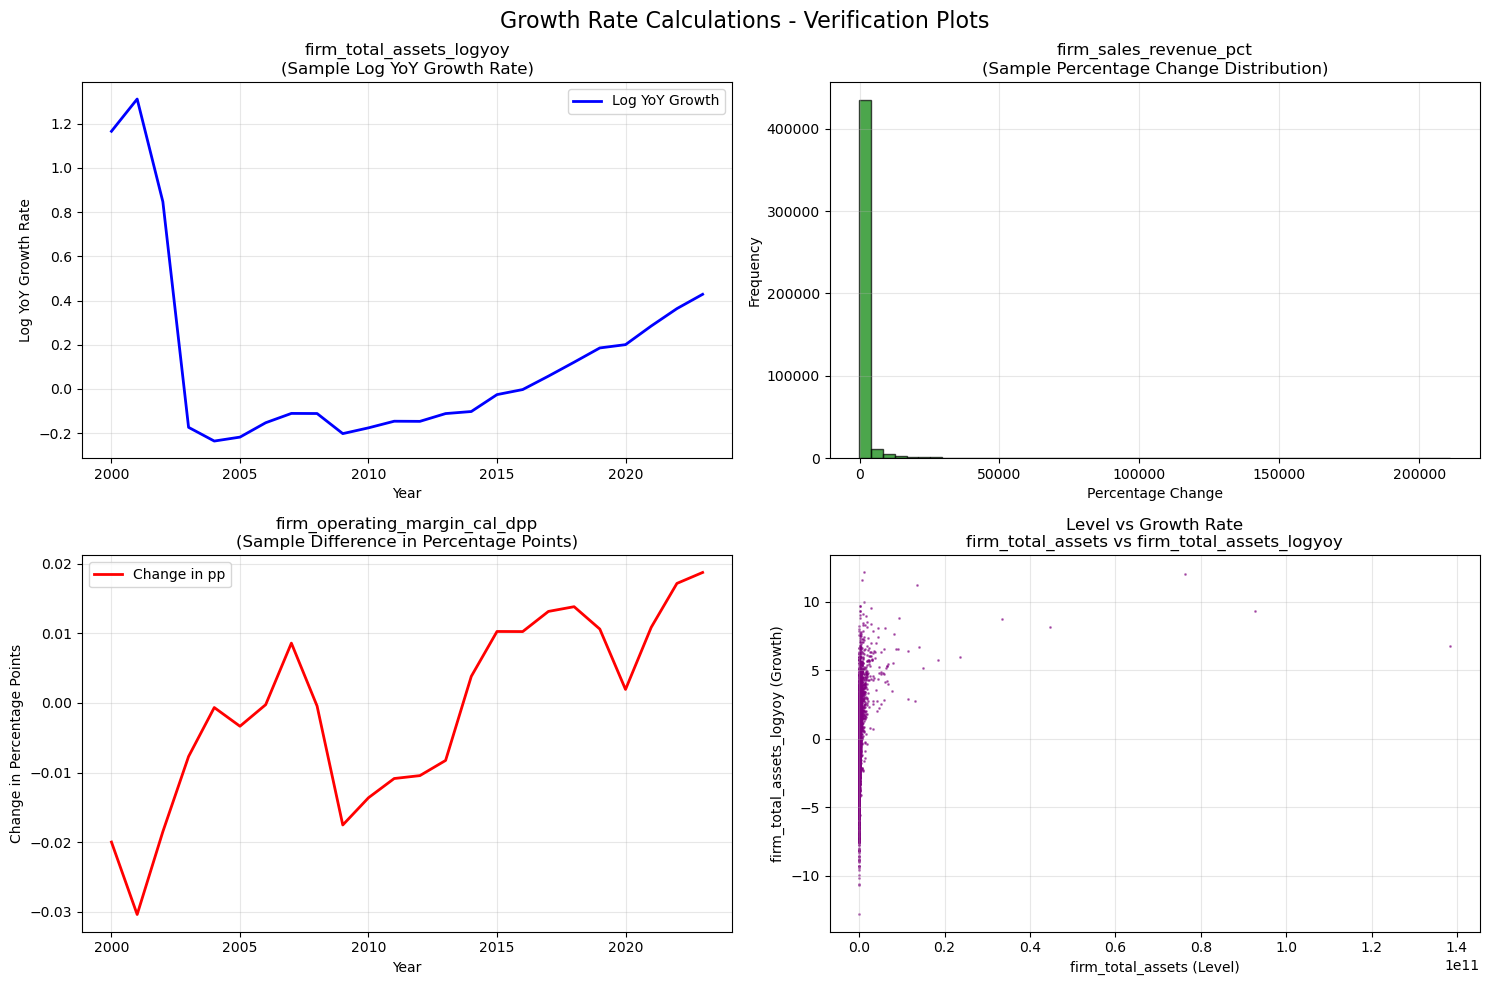


Summary Statistics for Growth Rate Variables:
shape: (10, 7)
┌────────────────────────────────┬────────┬────────┬───────────┬──────────┬────────────┬───────────┐
│ variable                       ┆ count  ┆ nulls  ┆ mean      ┆ std      ┆ min        ┆ max       │
│ ---                            ┆ ---    ┆ ---    ┆ ---       ┆ ---      ┆ ---        ┆ ---       │
│ str                            ┆ i64    ┆ i64    ┆ f64       ┆ f64      ┆ f64        ┆ f64       │
╞════════════════════════════════╪════════╪════════╪═══════════╪══════════╪════════════╪═══════════╡
│ firm_total_assets_logyoy       ┆ 582851 ┆ 82206  ┆ 0.027958  ┆ 2.731812 ┆ -15.157007 ┆ 17.350792 │
│ sector_avg_wages_by_nace_logyo ┆ 659681 ┆ 5376   ┆ 0.000698  ┆ 0.217482 ┆ -2.340382  ┆ 1.231547  │
│ …                              ┆        ┆        ┆           ┆          ┆            ┆           │
│ sector_ppi_by_nace_logyoy      ┆ 620065 ┆ 44992  ┆ 0.002045  ┆ 0.098053 ┆ -1.48451   ┆ 0.71558   │
│ sector_no_of_employees_by_n

In [8]:
# Visualization to verify calculated growth rates
print("Creating visualizations to verify growth rate calculations...")

# Convert to pandas for easier plotting
df_plot = df_transformed.to_pandas()

# Create subplots for different types of growth rates
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Growth Rate Calculations - Verification Plots', fontsize=16)

# 1. Plot time series of a sample log YoY growth rate
if log_yoy_cols:
    sample_col = log_yoy_cols[0]
    original_col = sample_col.replace("_logyoy", "")
    
    # Aggregate by year (mean) for plotting
    if original_col in df_plot.columns:
        yearly_data = df_plot.groupby('year').agg({
            original_col: 'mean',
            sample_col: 'mean'
        }).reset_index()
        
        ax1 = axes[0, 0]
        ax1.plot(yearly_data['year'], yearly_data[sample_col], 'b-', linewidth=2, label='Log YoY Growth')
        ax1.set_title(f'{sample_col}\n(Sample Log YoY Growth Rate)')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Log YoY Growth Rate')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

# 2. Plot histogram of a sample percentage change
if pct_cols:
    sample_col = pct_cols[0]
    
    ax2 = axes[0, 1]
    # Remove extreme outliers for better visualization
    plot_data = df_plot[sample_col].dropna()
    q1, q99 = plot_data.quantile([0.01, 0.99])
    plot_data_filtered = plot_data[(plot_data >= q1) & (plot_data <= q99)]
    
    ax2.hist(plot_data_filtered, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.set_title(f'{sample_col}\n(Sample Percentage Change Distribution)')
    ax2.set_xlabel('Percentage Change')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)

# 3. Plot time series of a sample difference in percentage points
if dpp_cols:
    sample_col = dpp_cols[0]
    
    # Aggregate by year (mean) for plotting
    yearly_data = df_plot.groupby('year')[sample_col].mean().reset_index()
    
    ax3 = axes[1, 0]
    ax3.plot(yearly_data['year'], yearly_data[sample_col], 'r-', linewidth=2, label='Change in pp')
    ax3.set_title(f'{sample_col}\n(Sample Difference in Percentage Points)')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Change in Percentage Points')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

# 4. Correlation plot between original and growth rate
if log_yoy_cols and len(log_yoy_cols) > 0:
    sample_growth_col = log_yoy_cols[0]
    original_col = sample_growth_col.replace("_logyoy", "")
    
    if original_col in df_plot.columns:
        # Create scatter plot of level vs growth rate
        ax4 = axes[1, 1]
        
        # Sample data to avoid overplotting
        sample_data = df_plot[[original_col, sample_growth_col]].dropna().sample(n=min(5000, len(df_plot)), random_state=42)
        
        ax4.scatter(sample_data[original_col], sample_data[sample_growth_col], 
                   alpha=0.5, s=1, color='purple')
        ax4.set_title(f'Level vs Growth Rate\n{original_col} vs {sample_growth_col}')
        ax4.set_xlabel(f'{original_col} (Level)')
        ax4.set_ylabel(f'{sample_growth_col} (Growth)')
        ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\nSummary Statistics for Growth Rate Variables:")
print("=" * 60)

# Create a summary table
summary_stats = []
for col in new_columns[:10]:  # First 10 columns
    if col in df_transformed.columns:
        stats = df_transformed.select([
            pl.lit(col).alias("variable"),
            pl.col(col).count().alias("count"),
            pl.col(col).null_count().alias("nulls"),
            pl.col(col).mean().alias("mean"),
            pl.col(col).std().alias("std"),
            pl.col(col).min().alias("min"),
            pl.col(col).max().alias("max")
        ]).to_dicts()[0]
        summary_stats.append(stats)

if summary_stats:
    summary_df = pl.DataFrame(summary_stats)
    print(summary_df)
else:
    print("No growth rate variables found for summary.")

In [9]:
# Save the transformed dataset and create documentation
print("Saving transformed dataset and creating documentation...")
print("=" * 60)

# 1. Save the transformed dataset
df_transformed.write_parquet(output_path)
print(f"✓ Transformed dataset saved to: {output_path}")
print(f"  - Shape: {df_transformed.shape}")
print(f"  - Original columns: {len(df.columns)}")
print(f"  - New growth rate columns: {len(new_columns)}")
print(f"  - Total columns: {len(df_transformed.columns)}")

# 2. Create documentation for the new variables
doc_path = output_path.replace('.parquet', '_growth_variables_docs.txt')
with open(doc_path, 'w') as f:
    f.write("Growth Rate Variables Documentation\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Source dataset: {input_path}\n")
    f.write(f"Output dataset: {output_path}\n\n")
    
    f.write("TRANSFORMATION FORMULAS:\n")
    f.write("-" * 30 + "\n")
    f.write("1. Log Year-over-Year Growth (_logyoy):\n")
    f.write("   Formula: X_logyoy_t = ln(X_t) - ln(X_{t-1})\n")
    f.write("   Use: Continuous growth rates for level/index series\n\n")
    
    f.write("2. Percentage Change (_pct):\n")
    f.write("   Formula: X_pct_t = 100*(X_t / X_{t-1} - 1)\n")
    f.write("   Use: Intuitive percentage changes\n\n")
    
    f.write("3. Difference in Percentage Points (_dpp):\n")
    f.write("   Formula: X_dpp_t = X_t - X_{t-1}\n")
    f.write("   Use: Changes in rates, shares, ratios\n\n")
    
    f.write("4. Base-100 Index (_pct):\n")
    f.write("   Formula: X_pct = X - 100\n")
    f.write("   Use: Convert base-100 index to percentage\n\n")
    
    f.write("VARIABLE LISTING:\n")
    f.write("-" * 30 + "\n")
    
    # Group variables by transformation type
    for transform_type in ["_logyoy", "_pct", "_dpp"]:
        vars_of_type = [col for col in new_columns if col.endswith(transform_type)]
        if vars_of_type:
            f.write(f"\n{transform_type.upper()} Variables ({len(vars_of_type)}):\n")
            for var in sorted(vars_of_type):
                f.write(f"  - {var}\n")

print(f"✓ Documentation saved to: {doc_path}")

# 3. Create a summary report
print(f"\n📊 FINAL SUMMARY REPORT")
print("=" * 60)
print(f"Input dataset: {input_path}")
print(f"Output dataset: {output_path}")
print(f"")
print(f"Dataset transformation completed:")
print(f"  • Original shape: {df.shape}")
print(f"  • Final shape: {df_transformed.shape}")
print(f"  • New growth rate variables: {len(new_columns)}")
print(f"")
print(f"Variable breakdown:")
print(f"  • Log YoY growth (_logyoy): {len([c for c in new_columns if c.endswith('_logyoy')])}")
print(f"  • Percentage change (_pct): {len([c for c in new_columns if c.endswith('_pct')])}")
print(f"  • Difference in pp (_dpp): {len([c for c in new_columns if c.endswith('_dpp')])}")
print(f"")
print(f"Key files created:")
print(f"  • {output_path}")
print(f"  • {doc_path}")
print(f"")
print(f"🎉 Growth rate calculations completed successfully!")
print(f"   Ready for econometric analysis in src_03_analysis/")

# 4. Basic validation check
print(f"\n🔍 FINAL VALIDATION CHECK")
print("-" * 30)
# Check that we have reasonable number of non-null observations
sample_growth_col = new_columns[0] if new_columns else None
if sample_growth_col:
    validation_stats = df_transformed.select([
        pl.len().alias("total_rows"),
        pl.col(sample_growth_col).count().alias("non_null_growth"),
        pl.col("year").min().alias("min_year"),
        pl.col("year").max().alias("max_year")
    ]).to_dicts()[0]
    
    print(f"Sample validation ({sample_growth_col}):")
    print(f"  • Total rows: {validation_stats['total_rows']:,}")
    print(f"  • Non-null growth rates: {validation_stats['non_null_growth']:,}")
    print(f"  • Coverage: {validation_stats['non_null_growth']/validation_stats['total_rows']:.1%}")
    print(f"  • Year range: {validation_stats['min_year']} - {validation_stats['max_year']}")
    
    if validation_stats['non_null_growth'] > 0:
        print(f"  ✓ Growth rate calculations appear successful")
    else:
        print(f"  ✗ No growth rate values calculated - check data")
else:
    print("No growth rate variables to validate")

Saving transformed dataset and creating documentation...
✓ Transformed dataset saved to: ../data/data_ready/merged_panel_clean.parquet
  - Shape: (665057, 163)
  - Original columns: 98
  - New growth rate columns: 65
  - Total columns: 163


NameError: name 'pd' is not defined